In [1]:
!pip install vaderSentiment

In [2]:
!pip install -q -U keras-tuner

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from nltk.tokenize import regexp_tokenize
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import defaultdict
import re, nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.patches as mpatches
import random
from sklearn import metrics
import re
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag, corpus
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import warnings
from sklearn.metrics import precision_recall_curve


In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_p

True

In [5]:
#UMICH SI650 - Sentiment Classification
#https://www.kaggle.com/competitions/si650winter11/data

In [6]:
! pip install -q kaggle
! mkdir ~/.kaggle

In [7]:
#Choose the kaggle.json file that you downloaded
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle competitions download -c si650winter11
! unzip si650winter11.zip -d si650winter11

  0% 0.00/506k [00:00<?, ?B/s]
100% 506k/506k [00:00<00:00, 109MB/s]
Archive:  si650winter11.zip
  inflating: si650winter11/testdata.txt  
  inflating: si650winter11/training.txt  


In [4]:
#Read test and train datasets
# header=0 -> first line contains column names
# delimiter=\t -> fields are separated by tabs
# quoting=3 -> ignore double quotes

train_data_df  = pd.read_table('si650winter11/training.txt', names=['sentiment', 'comment'], header=None, delimiter="\t", quoting=3)
test_data_df  = pd.read_table('si650winter11/testdata.txt', names=['comment'], header=None, delimiter="\t", quoting=3)

In [5]:
test_data_df.head(5)

,comment
0,""" I don't care what anyone says, I like Hillar..."
1,have an awesome time at purdue!..
2,"Yep, I'm still in London, which is pretty awes..."
3,"Have to say, I hate Paris Hilton's behavior bu..."
4,i will love the lakers.


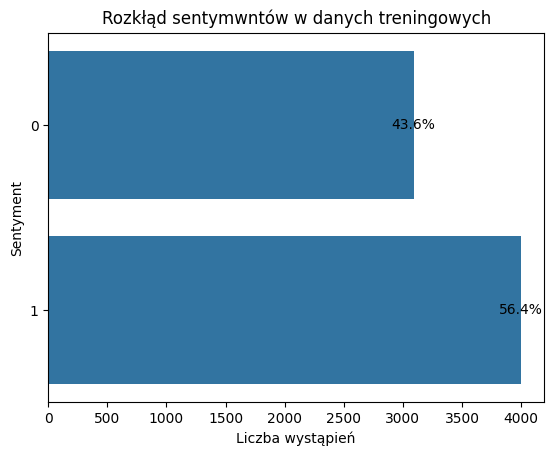

In [11]:
ax = sns.countplot(y="sentiment", data=train_data_df)
ax.set(title="Rozkłąd sentymwntów w danych treningowych", xlabel="Liczba wystąpień", ylabel="Sentyment")
total_freq = len(train_data_df)
for p in ax.patches:
    percentage = f'{100 * p.get_width() / total_freq:.1f}%'
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

In [12]:
#number words per sentence
np.mean([len(s.split(" ")) for s in train_data_df.comment])

10.886819079875812

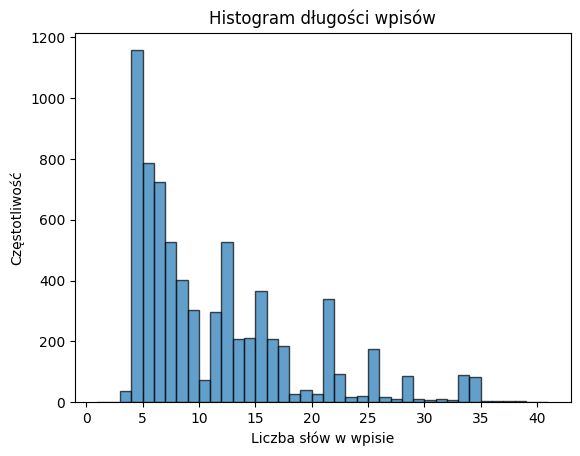

In [13]:
#Make a frequency list of lengths of tokenized each sentences
list_freq = [len(regexp_tokenize(s, "\w+")) for s in train_data_df["comment"]]

# Plot a histogram of the line lengths
#plt.figure(figsize=(8, 6))  # Ustawienie rozmiaru figury
plt.hist(list_freq, bins=range(1, max(list_freq) + 2), edgecolor='black', alpha=0.7)
plt.title("Histogram długości wpisów")
plt.xlabel("Liczba słów w wpisie")
plt.ylabel("Częstotliwość")
plt.show()

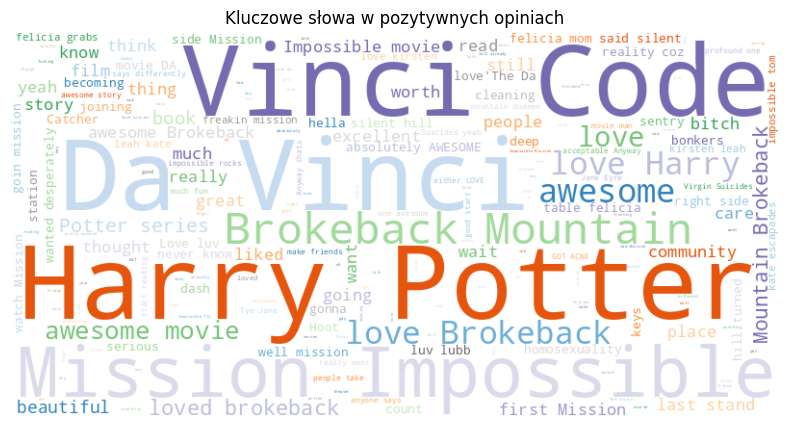

In [14]:
positive_comments = train_data_df[train_data_df['sentiment']==1]['comment']
text = " ".join(review for review in positive_comments)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab20c').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Kluczowe słowa w pozytywnych opiniach")
plt.axis('off')
plt.show()

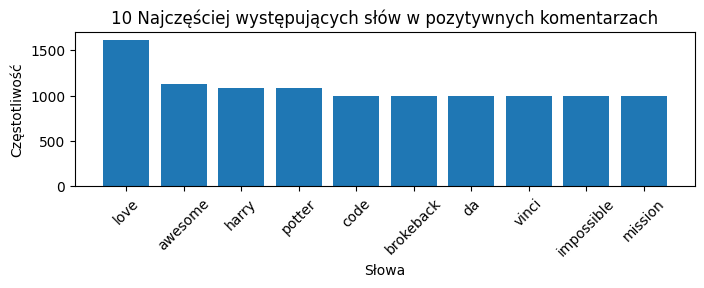

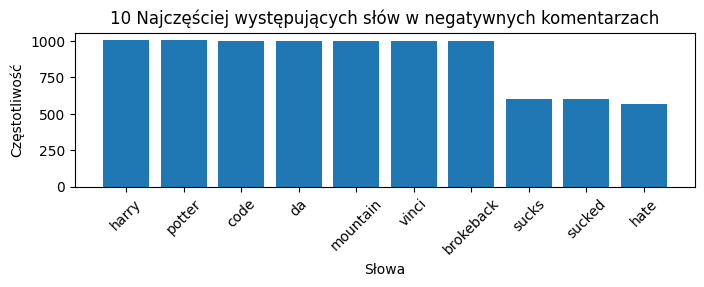

In [7]:
vectorizer = CountVectorizer(stop_words='english')

positive_comments = train_data_df[train_data_df['sentiment'] == 1]['comment']
positive_matrix = vectorizer.fit_transform(positive_comments)
positive_freq = zip(vectorizer.get_feature_names_out(), positive_matrix.sum(axis=0).tolist()[0])
positive_freq = sorted(positive_freq, key=lambda x: -x[1])

negative_comments = train_data_df[train_data_df['sentiment'] == 0]['comment']
negative_matrix = vectorizer.fit_transform(negative_comments)
negative_freq = zip(vectorizer.get_feature_names_out(), negative_matrix.sum(axis=0).tolist()[0])
negative_freq = sorted(negative_freq, key=lambda x: -x[1])

#Create histogram for top frequent words in positive comments
labels_pos, values_pos = zip(*positive_freq[:10])
plt.figure(figsize=(8,2))
plt.bar(labels_pos, values_pos)
plt.title('10 Najczęściej występujących słów w pozytywnych komentarzach')
plt.ylabel('Częstotliwość')
plt.xlabel('Słowa')
plt.xticks(rotation=45)
plt.show()
#Create histogram for top frequent words in negative comments
labels_neg, values_neg = zip(*negative_freq[:10])
plt.figure(figsize=(8,2))
plt.bar(labels_neg, values_neg)
plt.title('10 Najczęściej występujących słów w negatywnych komentarzach')
plt.ylabel('Częstotliwość')
plt.xlabel('Słowa')
plt.xticks(rotation=45)
plt.show()

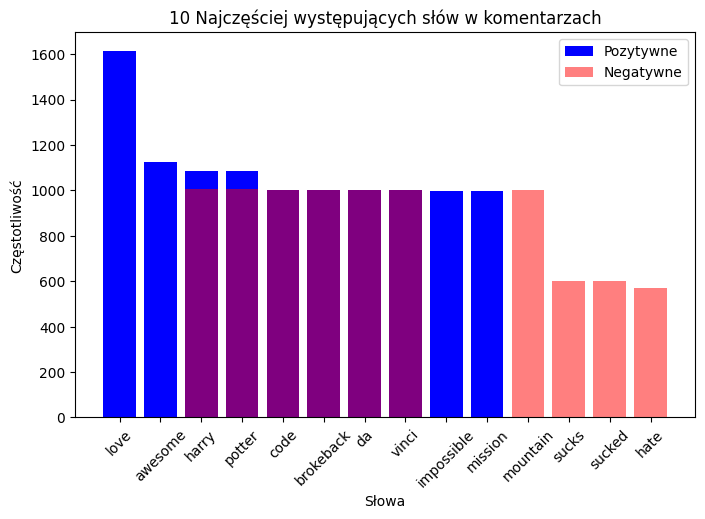

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(labels_pos, values_pos, color='blue', label='Pozytywne')
ax.bar(labels_neg, values_neg, color='red', label='Negatywne', alpha=0.5)
ax.set_title('10 Najczęściej występujących słów w komentarzach')
ax.set_ylabel('Częstotliwość')
ax.set_xlabel('Słowa')
ax.legend()
plt.xticks(rotation=45)
plt.show()

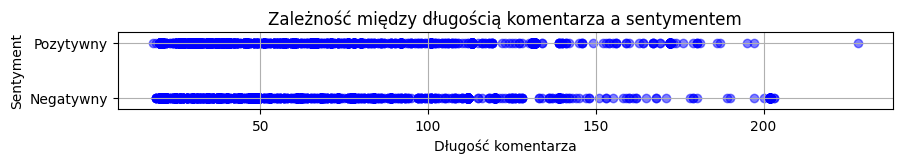

In [17]:
plt.figure(figsize=(10, 1))
plt.scatter(train_data_df['comment'].apply(len), train_data_df['sentiment'], color='blue', alpha=0.5)  # Set transparency for better visibility when points overlap
plt.title('Zależność między długością komentarza a sentymentem')
plt.xlabel('Długość komentarza')
plt.ylabel('Sentyment')
plt.yticks([0, 1], ["Negatywny", "Pozytywny"])
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.show()

In [19]:
#Dictionary to store sentiment lists for every word
sentiment_dict = defaultdict(list)

rows = []
for _, row in train_data_df.iterrows():
    words = row['comment'].lower().split()
    for word in words:
        sentiment_dict[word].append(row['sentiment'])

def determine_color(sentiments):
    if all(s == 1 for s in sentiments):
        return 'green'
    elif all(s == 0 for s in sentiments):
        return 'red'
    else:
        return 'orange'

color_dict = {word: determine_color(sentiments) for word, sentiments in sentiment_dict.items()}

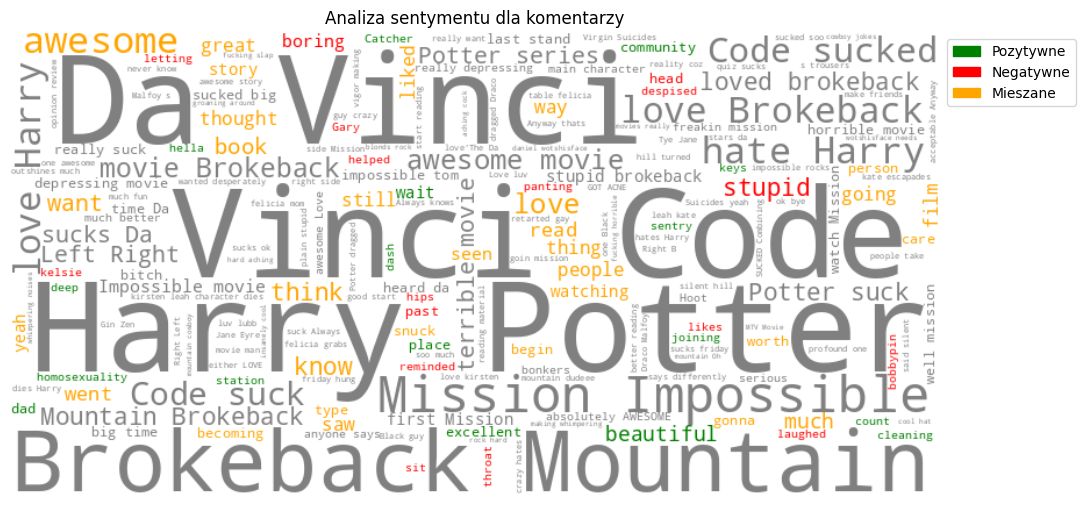

In [20]:
#Function color_func use color dictionary
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return color_dict.get(word.lower(), 'grey')

text = ' '.join(train_data_df['comment'])

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(text)
legend_elements = [
    mpatches.Patch(color='green', label='Pozytywne'),
    mpatches.Patch(color='red', label='Negatywne'),
    mpatches.Patch(color='orange', label='Mieszane')
]
plt.figure(figsize=(12, 7))
#plt.subplot(121)  # Użyj subplot, aby zrobić miejsce na legendę
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Analiza sentymentu dla komentarzy')
plt.axis('off')
plt.show()


In [21]:
#Preprocessing

In [10]:
def stem_tokens(tokens, stemmer):
  return [stemmer.stem(item) for item in tokens]

def tokenize(text):
  text = re.sub("[^a-zA-Z]", " ", text) #remove non letters
  tokens = nltk.word_tokenize(text) #tokenize
  stems = stem_tokens(tokens, PorterStemmer()) #stem
  return stems

In [18]:
count_vect = CountVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, max_features=100, token_pattern=None)
#fits the model, model learns the vocabulary and transforms corpus data into feature vectors
comment_tf = count_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
#to numpy
comment_tf_nd = comment_tf.toarray()
comment_tf_nd.shape

(40138, 100)

In [25]:
print("Comments term frequency (CountVectorize): ")
pd.DataFrame(comment_tf_nd, columns=count_vect.get_feature_names_out()).head(5)

Comments term frequency (CountVectorize): 


,aaa,airlin,amaz,angelina,awesom,beauti,becaus,big,boston,brokeback,...,toyota,ucla,ve,vinci,wa,want,way,whi,work,world
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [17]:
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, max_features=100, smooth_idf=False, token_pattern=None)
comment_tfidf = tfidf_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
comment_tfidf_nd = comment_tfidf.toarray()
print(comment_tfidf_nd.shape)

(40138, 100)


In [27]:
print("Comments term frequency-inverse document frequency (tf-idf):")
pd.DataFrame(comment_tfidf_nd, columns=tfidf_vect.get_feature_names_out()).head(5)

Comments term frequency-inverse document frequency (tf-idf):


,aaa,airlin,amaz,angelina,awesom,beauti,becaus,big,boston,brokeback,...,toyota,ucla,ve,vinci,wa,want,way,whi,work,world
0,0.0,0.0,0.0,0.0,0.391895,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.442319,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.384584,0.310759,0.272596,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.420995,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.420995,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.421334,0.000000,0.0,0.0,0.0,0.0,0.0


In [24]:
#words in vocabulary
vocab = count_vect.get_feature_names_out()
print(vocab)

['a' 'aaa' 'about' 'an' 'and' 'angelina' 'are' 'as' 'at' 'awesom' 'be'
 'beauti' 'becaus' 'been' 'boston' 'brokeback' 'but' 'by' 'can' 'code'
 'cruis' 'da' 'even' 'for' 'francisco' 'geico' 'go' 'great' 'harri'
 'harvard' 'hate' 'have' 'he' 'hilton' 'honda' 'i' 'imposs' 'in' 'is' 'it'
 'joli' 'just' 'laker' 'like' 'london' 'love' 'm' 'macbook' 'me' 'miss'
 'mission' 'mit' 'more' 'mountain' 'movi' 'much' 'my' 'need' 'not' 'of'
 'on' 'one' 'or' 'out' 'pari' 'peopl' 'potter' 'purdu' 'realli' 's' 'san'
 'seattl' 'shanghai' 'so' 'still' 'stupid' 'suck' 't' 'than' 'that' 'the'
 'thi' 'think' 'to' 'tom' 'too' 'toyota' 'ucla' 'up' 'vinci' 'wa' 'want'
 'way' 'we' 'when' 'which' 'who' 'with' 'would' 'you']


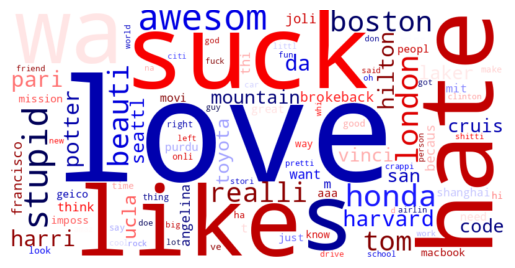

In [29]:
sum_vocab = np.sum(comment_tf_nd, axis=0)
word_frequencies = dict(zip(vocab, sum_vocab))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='seismic',).generate_from_frequencies(word_frequencies)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Classification**

In [20]:
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
model_metrics = {}
model_metrics_temp = {}
#     }
def add_model_metrics(model_name, y_test, y_pred, y_probs, dict_name = "final"):

    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_probs)
    pr_auc = metrics.auc(recall, precision)

    if dict_name == "final":
      model_metrics[model_name] = {
        'y_pred' : y_pred,
        'y_probs' : y_probs,
        'auc': metrics.roc_auc_score(y_test, y_probs),
        'precision': metrics.precision_score(y_test, y_pred),
        'recall': metrics.recall_score(y_test, y_pred),
        'f1_score': metrics.f1_score(y_test, y_pred),
        'roc_auc': metrics.roc_auc_score(y_test, y_pred),
        'pr_auc': pr_auc,
        'log_loss': metrics.log_loss(y_test, y_probs)
      }
    if dict_name == "selection":
      model_metrics_temp[model_name] = {
          'y_pred' : y_pred,
          'y_probs' : y_probs,
          'auc': metrics.roc_auc_score(y_test, y_probs),
          'precision': metrics.precision_score(y_test, y_pred),
          'recall': metrics.recall_score(y_test, y_pred),
          'f1_score': metrics.f1_score(y_test, y_pred),
          'roc_auc': metrics.roc_auc_score(y_test, y_pred),
          'pr_auc': pr_auc,
          'log_loss': metrics.log_loss(y_test, y_probs)
          }

In [45]:
def calculate_weighted_score(metrics, weights):
    total_weight = sum(weights.values())
    aggregated_score = sum(metrics[metric] * weights[metric] for metric in metrics if metric in weights)

    if total_weight == 0:
        raise ValueError("The sum of the weights cannot be equal to zero.")

    return aggregated_score / total_weight

In [46]:
def calculate_aggregated_metric_from_dict(data, weights):

    normalized_data = {key.capitalize(): value for key, value in data.items() if key.capitalize() in weights}
    return calculate_weighted_score(normalized_data, weights)

Zagregowana metryka: 0.61546


In [121]:
def select_best_model(model_metrics_temp=model_metrics_temp, drop = True):
  best_model = None
  best_score = -float('inf')  # Initialize to negative infinity
  best_model_metrics = {}

  for model_name, model_measures in model_metrics_temp.items():
    weights = {'Precision': 0.2, 'Recall': 0.2, 'F1 Score': 0.3, 'Auc': 0.2}

    normalized_measures = {key.capitalize(): value for key, value in model_measures.items() if key.capitalize() in weights}

    # Normalize keys and calculate the score using weighted sum of the selected metrics
    score = calculate_aggregated_metric_from_dict(normalized_measures, weights)
    print("Model name: ", model_name, "-> SCORE: ", score)

    # Check if this model has a higher score
    if score > best_score:
      best_score = score
      best_model = model_name
      best_model_metrics = model_measures

  # Display the best model's metrics
  if best_model:
    print(f"Selected best model: {best_model}")
    # Save the best model metrics to a new dictionary for further usage
    model_metrics[best_model] = best_model_metrics
    #for key, value in best_model_metrics.items():
    print("Best model metrics:")
    print(*(f"{k}: {v}" for k, v in list(best_model_metrics.items())[2:]), sep="\n")
    if drop == True:
      model_metrics_temp.clear()
  else:
    print("No valid models were found.")

In [124]:
select_best_model()

Model name:  log_sw -> SCORE:  0.5856558172549684
Model name:  log_tfidf -> SCORE:  0.66142900123064
Selected best model: log_tfidf
Best model metrics:
auc: 0.9984525275599014
precision: 0.988988988988989
recall: 0.988988988988989
f1_score: 0.988988988988989
roc_auc: 0.9873793586600832
pr_auc: 0.998991728363986
log_loss: 0.04341056431202173


In [33]:
# find some good and bad words
df = pd.DataFrame(comment_tf_nd, columns=count_vect.get_feature_names_out())
selected_words = ['awesom', 'good', 'great', 'like', 'shitti', 'stupid', 'suck']
sum_data = dict()

for word in selected_words:
  if word in df.columns.to_list():
    sum_data[word] = df[word].sum()
  else:
    print("Word:", word, "not within the list")
print("Word frequency:", sum_data)
#sum_data
df_subset = df[sum_data.keys()]
X_train, X_test, y_train, y_test  = train_test_split(df_subset[0:len(train_data_df)], train_data_df.sentiment,
                                                     train_size=0.75, random_state=1,
                                                     stratify=train_data_df.sentiment)


Word: good not within the list
Word: shitti not within the list
Word frequency: {'awesom': 3170, 'great': 1178, 'like': 4080, 'stupid': 2886, 'suck': 4614}


# **Logistic Regression**

In [87]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarnings
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [88]:
# Setup the pipeline
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

# Parameter grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  # Values of C (inverse of regularization strength)
    'logisticregression__penalty': ['l1', 'l2'],  # Types of regularization
    'logisticregression__solver': ['liblinear', 'saga']  # Solvers that support L1 regularization
}

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',
    verbose=1
)

# Fitting grid search
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X=X_test)
y_pred_prob_sw = best_model.predict_proba(X=X_test)[:,1]
fpr_sw, tpr_sw, thresholds = metrics.roc_curve(y_test, y_pred_prob_sw)
roc_auc_sw = metrics.auc(fpr_sw, tpr_sw)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


In [89]:
add_model_metrics('log_sw', y_test, y_pred, y_pred_prob_sw, "selection")

In [90]:
#tf-idf linear classifier
# train and validation set split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(comment_tfidf_nd[0:len(train_data_df)],
                                                                             train_data_df.sentiment,
                                                                             train_size=0.75,
                                                                             random_state=1,
                                                                             stratify=train_data_df.sentiment)


In [91]:
# Setup the pipeline
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

# Parameter grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  # Values of C (inverse of regularization strength)
    'logisticregression__penalty': ['l1', 'l2'],  # Types of regularization
    'logisticregression__solver': ['liblinear', 'saga']  # Solvers that support L1 regularization
}

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',
    verbose=1
)

# Fitting grid search
grid_search.fit(X_train_tfidf, y_train_tfidf)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predictions with the best model
y_pred_tfidf = best_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf = best_model.predict_proba(X=X_test_tfidf)[:, 1]
print(metrics.classification_report(y_test_tfidf, y_pred_tfidf))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       773
           1       0.99      0.99      0.99       999

    accuracy                           0.99      1772
   macro avg       0.99      0.99      0.99      1772
weighted avg       0.99      0.99      0.99      1772



In [92]:
fpr_tfidf, tpr_tfidf, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
roc_auc_tfidf

0.9984525275599014

In [93]:
add_model_metrics('log_tfidf', y_test_tfidf, y_pred_tfidf, y_pred_prob_tfidf, "selection")

In [41]:
#tf linear classifier
# train and validation set split
X_train_tf, X_test_tf, y_train_tf, y_test_tf  = train_test_split(comment_tf_nd[0:len(train_data_df)],
                                                                 train_data_df.sentiment,
                                                                 train_size=0.75,
                                                                 random_state=1,
                                                                 stratify=train_data_df.sentiment)

# Setup the pipeline
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

# Parameter grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  # Values of C (inverse of regularization strength)
    'logisticregression__penalty': ['l1', 'l2'],  # Types of regularization
    'logisticregression__solver': ['liblinear', 'saga']  # Solvers that support L1 regularization
}

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',
    verbose=1
)

# Fitting grid search
grid_search.fit(X=X_train_tf, y=y_train_tf)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# classifier to label an evaluation set
y_pred_tf = best_model.predict(X=X_test_tf)
y_pred_prob_tf = best_model.predict_proba(X=X_test_tf)[:,1]

print(metrics.classification_report(y_test_tf, y_pred_tf))
fpr_tf, tpr_tf, thresholds = metrics.roc_curve(y_test_tf, y_pred_prob_tf)
roc_auc_tf = metrics.auc(fpr_tf, tpr_tf)
roc_auc_tf

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       773
           1       0.99      0.99      0.99       999

    accuracy                           0.99      1772
   macro avg       0.99      0.99      0.99      1772
weighted avg       0.99      0.99      0.99      1772



0.9983897221930856

In [42]:
add_model_metrics('log_tf', y_test_tf, y_pred_tf, y_pred_prob_tf, "selection")

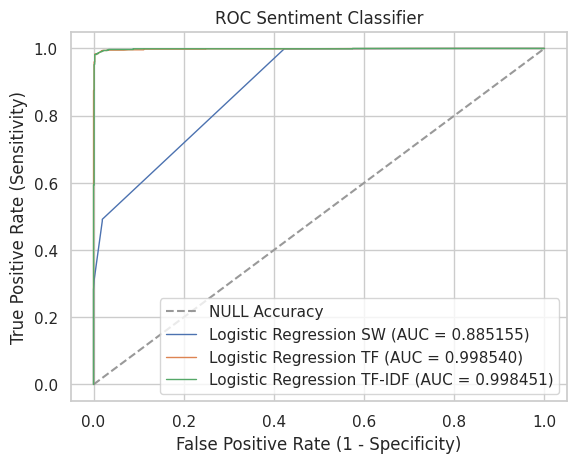

In [44]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [46]:
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100, smooth_idf=True)
comment_tfidf = tfidf_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
comment_tfidf_nd = comment_tfidf.toarray()
comment_tfidf_nd.shape
#tf-idf linear classifier
# train and validation set split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf  = train_test_split(comment_tfidf_nd[0:len(train_data_df)], train_data_df.sentiment,
                                                                             train_size=0.75, random_state=1,
                                                                             stratify=train_data_df.sentiment)

# Setup the pipeline
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

# Parameter grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  # Values of C (inverse of regularization strength)
    'logisticregression__penalty': ['l1', 'l2'],  # Types of regularization
    'logisticregression__solver': ['liblinear', 'saga']  # Solvers that support L1 regularization
}

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',
    verbose=1
)

# Fitting grid search
grid_search.fit(X_train_tfidf, y=y_train_tfidf)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# classifier to label an evaluation set
y_pred_tfidf = best_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf = best_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_smooth, tpr_tfidf_smooth, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf)
roc_auc_tfidf_smooth = metrics.auc(fpr_tfidf_smooth, tpr_tfidf_smooth)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


In [47]:
add_model_metrics('log_tfidf_smooth', y_test_tfidf, y_pred_tfidf, y_pred_prob_tfidf, "selection")

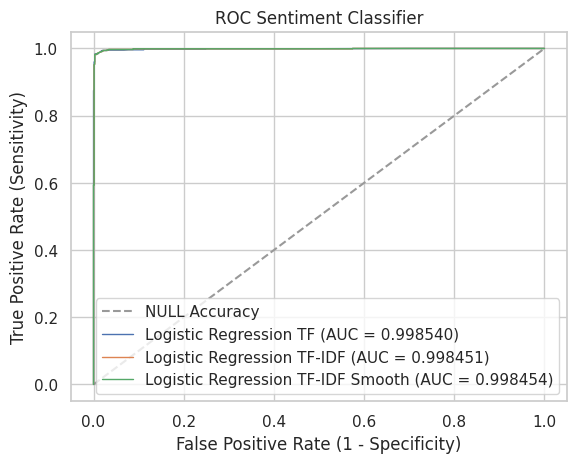

In [48]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

**Select the best Logistic Regression model** </br>
**Calculate the mean of the metrics for each model and finds the model with the best (highest) score**



In [49]:
#Choose the best model
select_best_model()

final: 0.701055413410383
final: 0.7947621431416143
final: 0.7947945825679636
final: 0.7947631791064276
All Models' Metrics:
      Model Name      AUC  Precision   Recall  F1 Score  ROC AUC   PR AUC
          log_sw 0.885155   0.753208 0.998999  0.858864 0.787986 0.926412
       log_tfidf 0.998451   0.991935 0.984985  0.988448 0.987318 0.998833
          log_tf 0.998540   0.992929 0.983984  0.988436 0.987464 0.999047
log_tfidf_smooth 0.998454   0.991935 0.984985  0.988448 0.987318 0.998835

Selected best model: log_tf
Metrics:
auc: 0.9985
precision: 0.9929
recall: 0.9840
f1_score: 0.9884
roc_auc: 0.9875
pr_auc: 0.9990
log_loss: 0.0411
This model has been saved to the final model_metrics dictionary.


# **VADER SentimentIntensityAnalyzer**

In [51]:
sia = SentimentIntensityAnalyzer()

train_data_df['vader_score'] = train_data_df['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
train_data_df['vader_pred'] = train_data_df['vader_score'].apply(lambda x: 1 if x >= 0 else 0)


fpr_vader, tpr_vader, thresholds_vader = metrics.roc_curve(train_data_df['sentiment'], train_data_df['vader_score'])
roc_auc_vader = metrics.auc(fpr_vader, tpr_vader)
print(roc_auc_vader)

add_model_metrics('VADER_SentimentAnalysis',
                  train_data_df['sentiment'],
                  train_data_df['vader_pred'],
                  train_data_df['vader_score'],
                  "selection")

0.9389753610648056


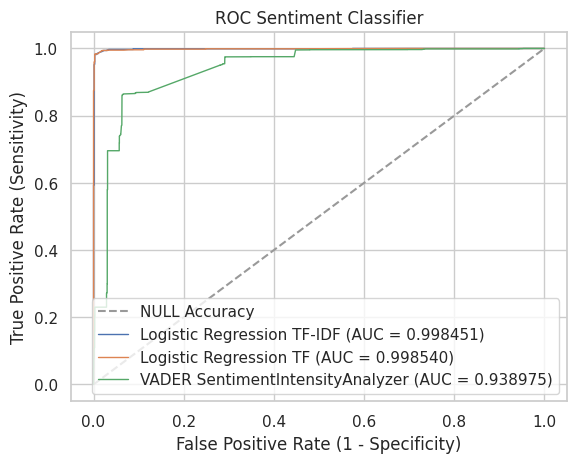

In [52]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [53]:
#Lemmatization with VADER
#Lemmatize the entire text without dividing it into sentences -> This simplifies the process, but may not take into account some of the linguistic nuances that arise from sentence structure.
#Lemmatization without specifying the part of speech

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])

In [54]:
tf.get_logger().setLevel('ERROR')  # Ignore anything less severe than ERROR

train_data_df['lemmatized_comment'] = train_data_df['comment'].apply(lemmatize_text)

sia = SentimentIntensityAnalyzer()

train_data_df['vader_lemma_score'] = train_data_df['lemmatized_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
train_data_df['vader_lemma_pred'] = train_data_df['vader_lemma_score'].apply(lambda x: 1 if x >= 0 else 0)
fpr_lemmatizer, tpr_lemmatizer, thresholds = metrics.roc_curve(train_data_df['sentiment'], train_data_df['vader_lemma_score'])
roc_auc_lemmatizer = metrics.auc(fpr_lemmatizer, tpr_lemmatizer)
print(roc_auc_lemmatizer)

add_model_metrics('VADER_Lemma',
                  train_data_df['sentiment'],
                  train_data_df['vader_lemma_pred'],
                  train_data_df['vader_lemma_score'],
                  "selection")

0.9505137244914278


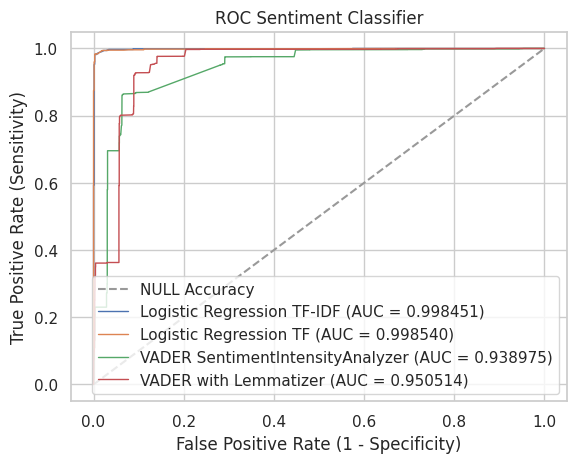

In [55]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [56]:
#Definition of the lemmatization function divided into sentences
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    sentences = sent_tokenize(text)
    lemmatized_output = []

    for sentence in sentences:
        words = word_tokenize(sentence)
        lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word) for word in words])
        lemmatized_output.append(lemmatized_sentence)

    return ' '.join(lemmatized_output)

In [57]:
from nltk.tokenize import sent_tokenize, word_tokenize
train_data_df['lemmatized_div_comment'] = train_data_df['comment'].apply(lemmatize_text)

sia = SentimentIntensityAnalyzer()

train_data_df['vader_lemma_div_score'] = train_data_df['lemmatized_div_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
train_data_df['vader_lemma_div_pred'] = train_data_df['vader_lemma_div_score'].apply(lambda x: 1 if x >= 0 else 0)
fpr_lem_div, tpr_lem_div, thresholds = metrics.roc_curve(train_data_df['sentiment'], train_data_df['vader_lemma_div_score'])
roc_auc_lem_div = metrics.auc(fpr_lem_div, tpr_lem_div)

add_model_metrics('VADER_Lemma_Div',
                  train_data_df['sentiment'],
                  train_data_df['vader_lemma_div_pred'],
                  train_data_df['vader_lemma_div_score'],
                  "selection")

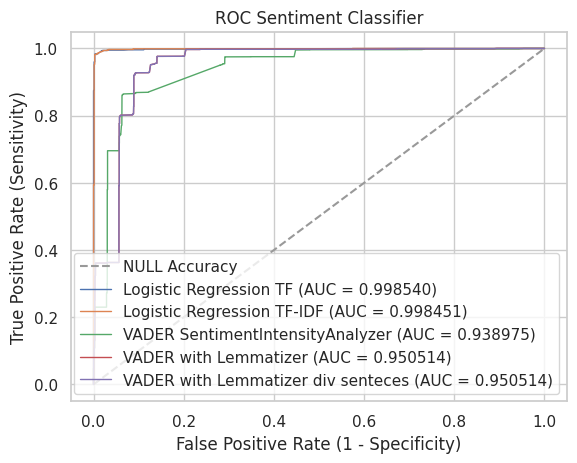

In [58]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [60]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(word):
    """Map NLTK POS tag to a format recognized by WordNetLemmatizer"""
    tag = pos_tag([word])[0][1][0].upper()  # Get the first character of the POS tag
    tag_dict = {
        "J": corpus.wordnet.ADJ,
        "N": corpus.wordnet.NOUN,
        "V": corpus.wordnet.VERB,
        "R": corpus.wordnet.ADV
    }
    return tag_dict.get(tag, corpus.wordnet.NOUN)  # Default to noun if no match

# Function to lemmatize text with proper POS tagging
def lemmatize_text(text):
    """Lemmatize text with POS tag mapping for better accuracy"""
    sentences = sent_tokenize(text)
    lemmatized_text = []

    # Process each sentence
    for sentence in sentences:
        words = word_tokenize(sentence)
        lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words])
        lemmatized_text.append(lemmatized_sentence)

    return ' '.join(lemmatized_text)


In [61]:
train_data_df['lemmatized2_comment'] = train_data_df['comment'].apply(lemmatize_text)

sia = SentimentIntensityAnalyzer()

train_data_df['lemma2__score'] = train_data_df['lemmatized2_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
train_data_df['vader_lemma2_pred'] = train_data_df['lemma2__score'].apply(lambda x: 1 if x >= 0 else 0)
fpr_lem2, tpr_lem2, thresholds = metrics.roc_curve(train_data_df['sentiment'], train_data_df['lemma2__score'])
roc_auc_lem2 = metrics.auc(fpr_lem2, tpr_lem2)

add_model_metrics('VADER_Lemma_Div',
                  train_data_df['sentiment'],
                  train_data_df['vader_lemma2_pred'],
                  train_data_df['lemma2__score'],
                  "selection")

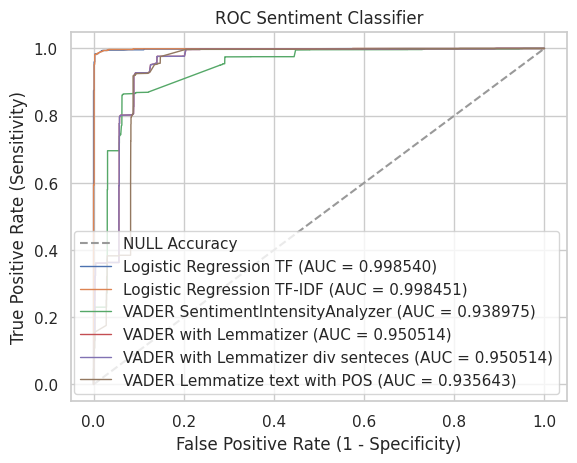

In [62]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_lem2, tpr_lem2, lw=1, label='VADER Lemmatize text with POS (AUC = %0.6f)' % roc_auc_lem2)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

**Calculate the mean of the metrics for each model and finds the model with the best (highest) score**

In [63]:
#Choose the best model
select_best_model()

final: 0.727449349440433
final: 0.7517846076890756
final: 0.7446991961706816
All Models' Metrics:
             Model Name      AUC  Precision   Recall  F1 Score  ROC AUC   PR AUC
VADER_SentimentAnalysis 0.938975   0.814552 0.949937  0.877051 0.835208 0.939983
            VADER_Lemma 0.950514   0.906749 0.951690  0.928676 0.912597 0.946249
        VADER_Lemma_Div 0.935643   0.900971 0.951940  0.925755 0.908354 0.921222

Selected best model: VADER_Lemma
Metrics:
auc: 0.9505
precision: 0.9067
recall: 0.9517
f1_score: 0.9287
roc_auc: 0.9126
pr_auc: 0.9462
log_loss: 1.7206
This model has been saved to the final model_metrics dictionary.


# **K-Neighbors Classifier**

In [64]:
pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluate model performance with Area Under Curve
    verbose=1  # Higher number gives more info about the process
)

grid_search.fit(X_train_tfidf, y_train_tfidf)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Making predictions with the best model
y_pred_tfid_knn = best_model.predict(X_test_tfidf)
y_pred_prob_tfidf_knn = best_model.predict_proba(X_test_tfidf)[:,1]

fpr_tfidf_knn, tpr_tfidf_knn, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_knn)
roc_auc_tfidf_knn = metrics.auc(fpr_tfidf_knn, tpr_tfidf_knn)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'uniform'}


In [65]:
add_model_metrics('KNN_tfidf', y_test_tfidf, y_pred_tfid_knn, y_pred_prob_tfidf_knn, "selection")

In [66]:
pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluate model performance with Area Under Curve
    verbose=1  # Higher number gives more info about the process
)

grid_search.fit(X=X_train_tf, y=y_train_tf)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Making predictions with the best model
y_pred_tf_knn = best_model.predict(X_test_tf)
y_pred_prob_tf_knn = best_model.predict_proba(X_test_tf)[:,1]

fpr_tf_knn, tpr_tf_knn, thresholds = metrics.roc_curve(y_test_tf, y_pred_prob_tf_knn)
roc_auc_tf_knn = metrics.auc(fpr_tf_knn, tpr_tf_knn)
print(roc_auc_tf_knn)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'uniform'}
0.9972145496078226


In [67]:
add_model_metrics('KNN_tf', y_test_tf, y_pred_tf_knn, y_pred_prob_tf_knn, "selection")

In [68]:
# Pipeline setup with StandardScaler and PCA
pipeline = make_pipeline(StandardScaler(), PCA(), KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluate model performance with Area Under Curve
    verbose=1  # Higher number gives more info about the process
)

grid_search.fit(X_train_tfidf, y_train_tfidf)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Making predictions with the best model
y_pred_tfid_pca_knn = best_model.predict(X_test_tfidf)
y_pred_prob_tfidf_pca_knn = best_model.predict_proba(X_test_tfidf)[:,1]

fpr_tfidf_pca_knn, tpr_tfidf_pca_knn, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_pca_knn)
roc_auc_tfidf_pca_knn = metrics.auc(fpr_tfidf_pca_knn, tpr_tfidf_pca_knn)
print(roc_auc_tfidf_pca_knn)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance'}
0.9939428432313296


In [69]:
add_model_metrics('KNN_tfidf_pca', y_test_tfidf, y_pred_tfid_pca_knn, y_pred_prob_tfidf_pca_knn, "selection")

In [70]:
# Pipeline setup with StandardScaler and PCA
pipeline = make_pipeline(StandardScaler(), PCA(), KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluate model performance with Area Under Curve
    verbose=1  # Higher number gives more info about the process
)

grid_search.fit(X=X_train_tf, y=y_train_tf)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Making predictions with the best model
y_pred_tf_pca_knn = best_model.predict(X_test_tf)
y_pred_prob_tf_pca_knn = best_model.predict_proba(X_test_tf)[:,1]

fpr_tf_pca_knn, tpr_tf_pca_knn, thresholds = metrics.roc_curve(y_test_tf, y_pred_prob_tf_pca_knn)
roc_auc_tf_pca_knn = metrics.auc(fpr_tf_pca_knn, tpr_tf_pca_knn)
print(roc_auc_tf_pca_knn)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance'}
0.9954495245568984


In [71]:
add_model_metrics('KNN_tf_pca', y_test_tf, y_pred_tf_pca_knn, y_pred_prob_tf_pca_knn, "selection")

In [72]:
#Choose the best KNN model
select_best_model()

final: 0.7890348879113548
final: 0.7922584168430875
final: 0.7859219839215339
final: 0.7869266697505493
All Models' Metrics:
   Model Name      AUC  Precision   Recall  F1 Score  ROC AUC   PR AUC
    KNN_tfidf 0.997124   0.975952 0.974975  0.975463 0.971964 0.997930
       KNN_tf 0.997215   0.986895 0.979980  0.983425 0.981581 0.998165
KNN_tfidf_pca 0.993943   0.974773 0.966967  0.970854 0.967313 0.995747
   KNN_tf_pca 0.995450   0.975782 0.967968  0.971859 0.968460 0.996565

Selected best model: KNN_tf
Metrics:
auc: 0.9972
precision: 0.9869
recall: 0.9800
f1_score: 0.9834
roc_auc: 0.9816
pr_auc: 0.9982
log_loss: 0.1004
This model has been saved to the final model_metrics dictionary.


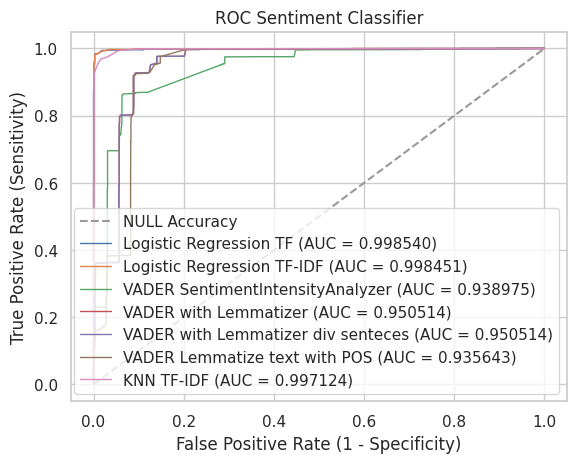

In [73]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_lem2, tpr_lem2, lw=1, label='VADER Lemmatize text with POS (AUC = %0.6f)' % roc_auc_lem2)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

# **Decision Tree Classifier**

In [74]:
# Setup the pipeline with a DecisionTreeClassifier
pipeline = make_pipeline(DecisionTreeClassifier(random_state=42))

param_grid = {
    'decisiontreeclassifier__max_depth': [None, 10, 20, 30, 40, 50],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluation metric to optimize
    verbose=1  # For detailed output
)

grid_search.fit(X_train_tfidf, y_train_tfidf)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_tfidf_dt = best_model.predict(X_test_tfidf)
y_pred_prob_tfidf_dt = best_model.predict_proba(X_test_tfidf)[:, 1]

# Calculate ROC curve and AUC
fpr_tfidf_dt, tpr_tfidf_dt, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_dt)
roc_auc_tfidf_dt = metrics.auc(fpr_tfidf_dt, tpr_tfidf_dt)

print("ROC AUC for the best Decision Tree model:", roc_auc_tfidf_dt)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 4, 'decisiontreeclassifier__min_samples_split': 10}
ROC AUC for the best Decision Tree model: 0.9973375704294203


In [75]:
add_model_metrics('DecisionTree_tfidf', y_test_tfidf, y_pred_tfidf_dt, y_pred_prob_tfidf_dt, "selection")

In [76]:
# Setup the pipeline with a DecisionTreeClassifier
pipeline = make_pipeline(DecisionTreeClassifier(random_state=42))

param_grid = {
    'decisiontreeclassifier__max_depth': [None, 10, 20, 30, 40, 50],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluation metric to optimize
    verbose=1  # For detailed output
)

grid_search.fit(X_train_tf, y_train_tf)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Use the best model to make predictions
y_pred_tf = best_model.predict(X_test_tf)
y_pred_prob_tf = best_model.predict_proba(X_test_tf)[:, 1]

fpr_tf, tpr_tf, thresholds = metrics.roc_curve(y_test_tf, y_pred_prob_tf)
roc_auc_tf = metrics.auc(fpr_tf, tpr_tf)

print("ROC AUC for the best Decision Tree model with TF features:", roc_auc_tf)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__min_samples_leaf': 4, 'decisiontreeclassifier__min_samples_split': 10}
ROC AUC for the best Decision Tree model with TF features: 0.9983178521341523


In [77]:
add_model_metrics('DecisionTree_tf', y_test_tf, y_pred_tf, y_pred_prob_tf, "selection")

In [78]:
pipeline = make_pipeline(RandomForestClassifier(random_state=42))

param_grid = {
    'randomforestclassifier__n_estimators': [10, 50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20, 30, 40],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # This can be changed to 'roc_auc' or other relevant metrics
    verbose=1  # For detailed output
)

# Assuming X_train_tf and y_train_tf are defined and prepared
grid_search.fit(X_train_tf, y_train_tf)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Use the best model to make predictions
y_pred_tf = best_model.predict(X_test_tf)
y_pred_prob_tf = best_model.predict_proba(X_test_tf)[:, 1]

fpr_tf, tpr_tf, thresholds = metrics.roc_curve(y_test_tf, y_pred_prob_tf)
roc_auc_tf = metrics.auc(fpr_tf, tpr_tf)

print("ROC AUC for the best Random Forest model with TF features:", roc_auc_tf)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 200}
ROC AUC for the best Random Forest model with TF features: 0.9993577018156579


In [79]:
add_model_metrics('RandomForest_tf', y_test_tf, y_pred_tf, y_pred_prob_tf, "selection")

In [80]:
pipeline = make_pipeline(RandomForestClassifier(random_state=42))

param_grid = {
    'randomforestclassifier__n_estimators': [10, 50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20, 30, 40],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # This can be changed to 'roc_auc' or other relevant metrics
    verbose=1  # For detailed output
)

grid_search.fit(X_train_tfidf, y_train_tfidf)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_tfidf_rf = best_model.predict(X_test_tfidf)
y_pred_prob_tfidf_rf = best_model.predict_proba(X_test_tfidf)[:, 1]

# Calculate ROC curve and AUC
fpr_tfidf_rf, tpr_tfidf_rf, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_rf)
roc_auc_tfidf_rf = metrics.auc(fpr_tfidf_rf, tpr_tfidf_rf)

print("ROC AUC for the best Random Forest model:", roc_auc_tfidf_rf)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 50}
ROC AUC for the best Random Forest model: 0.9992625225484216


In [81]:
add_model_metrics('RandomForest_tfidf', y_test_tfidf, y_pred_tfidf_rf, y_pred_prob_tfidf_rf, "selection")

In [82]:
#Choose the best DecisionTree model
select_best_model()

final: 0.7945402134080601
final: 0.7949227364492566
final: 0.7947356189818926
final: 0.7947025571928549
All Models' Metrics:
        Model Name      AUC  Precision   Recall  F1 Score  ROC AUC   PR AUC
DecisionTree_tfidf 0.997338   0.987039 0.990991  0.989011 0.987087 0.998422
   DecisionTree_tf 0.998318   0.988989 0.988989  0.988989 0.987379 0.998834
   RandomForest_tf 0.999358   0.987976 0.986987  0.987481 0.985732 0.999535
RandomForest_tfidf 0.999263   0.987000 0.987988  0.987494 0.985585 0.999480

Selected best model: DecisionTree_tf
Metrics:
auc: 0.9983
precision: 0.9890
recall: 0.9890
f1_score: 0.9890
roc_auc: 0.9874
pr_auc: 0.9988
log_loss: 0.0653
This model has been saved to the final model_metrics dictionary.


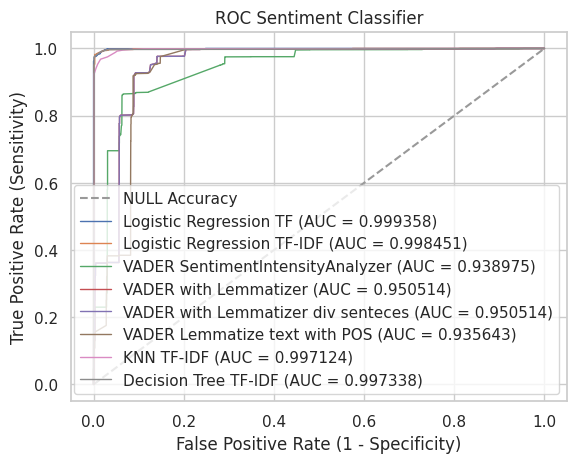

In [83]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_lem2, tpr_lem2, lw=1, label='VADER Lemmatize text with POS (AUC = %0.6f)' % roc_auc_lem2)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [127]:
# Preprocessing parameters
vocab_size = 20000  # Max number of words in dict
max_length = 100    # Max length sequence

# Tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data_df.comment)

# Convert txt to sequence
X = tokenizer.texts_to_sequences(train_data_df.comment)
X = pad_sequences(X, maxlen=max_length)

y = train_data_df.sentiment.values

# Train, validation set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [128]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
    model.add(keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined here based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='grid_search_cnn'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(X_test, y_test)

y_pred_prob_cnn = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_cnn = (y_pred_prob_cnn > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_cnn)
print("ROC AUC Score:", roc_auc)


Trial 3 Complete [00h 00m 17s]
val_loss: 0.2942676842212677

Best val_loss So Far: 0.019162962213158607
Total elapsed time: 00h 01m 22s
74/74 [==============================] - 1s 10ms/step
ROC AUC Score: 0.9997672232418641


In [129]:
add_model_metrics('CNN', y_test, y_pred_cnn, y_pred_prob_cnn, "selection")

In [87]:
# model_cnn = Sequential([
#     Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length),
#     Conv1D(filters=128, kernel_size=3, activation='relu'),
#     GlobalMaxPooling1D(),
#     Dense(10, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])
# model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
# model_cnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# y_pred_prob_cnn = model_cnn.predict(X_test).flatten()
# y_pred_cnn = (y_pred_prob_cnn > 0.5).astype(int)
# fpr_cnn, tpr_cnn, thresholds = metrics.roc_curve(y_test, y_pred_prob_cnn)
# roc_auc_cnn = metrics.auc(fpr_cnn, tpr_cnn)

# print(f"ROC AUC: {roc_auc_cnn}")


In [130]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
    model.add(keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())

    # Adding L1 and L2 regularization
    l1_value = hp.Choice('l1_reg', values=[1e-2, 1e-3, 1e-4])
    l2_value = hp.Choice('l2_reg', values=[1e-2, 1e-3, 1e-4])
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=100, step=10),
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(l1=l1_value, l2=l2_value)))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='grid_search_cnn'
)

# Make sure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_cnn = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_cnn = (y_pred_prob_cnn > 0.5).astype(int)  # Convert probabilities to binary class labels

#fpr_cnn, tpr_cnn, thresholds = metrics.roc_curve(y_test, y_pred_prob_cnn)
#roc_auc_cnn = metrics.auc(fpr_cnn, tpr_cnn)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_cnn)
print("ROC AUC Score:", roc_auc)


Trial 3 Complete [00h 00m 17s]
val_loss: 0.856333315372467

Best val_loss So Far: 0.03270864114165306
Total elapsed time: 00h 01m 14s
74/74 [==============================] - 1s 4ms/step - loss: 0.0327 - auc: 0.9995
Test Loss, Test AUC: [0.03270864114165306, 0.9994620680809021]
74/74 [==============================] - 0s 4ms/step
ROC AUC Score: 0.999696345703329


In [131]:
add_model_metrics('CNN_reg', y_test, y_pred_cnn, y_pred_prob_cnn, "selection")

In [132]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
    model.add(keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_conv', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout po warstwie konwolucyjnej
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=100, step=10),
        activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_dense', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout po warstwie Dense
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Przykład użycia tylko Dropout w tunerze
tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='grid_search_cnn'
)

# Upewnij się, że X_train, y_train, X_test, y_test są poprawnie zdefiniowane i przetworzone
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_cnn = best_model.predict(X_test).flatten()  # Pobierz prawdopodobieństwa
y_pred_cnn = (y_pred_prob_cnn > 0.5).astype(int)  # Konwertuj prawdopodobieństwa na etykiety klas binarnych

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_cnn)
print("ROC AUC Score:", roc_auc)


Trial 3 Complete [00h 00m 24s]
val_loss: 0.17413437366485596

Best val_loss So Far: 0.01869051903486252
Total elapsed time: 00h 01m 09s
74/74 [==============================] - 1s 4ms/step - loss: 0.0187 - auc: 0.9995
Test Loss, Test AUC: [0.01869051903486252, 0.9994665384292603]
74/74 [==============================] - 0s 3ms/step
ROC AUC Score: 0.9997015682588


In [133]:
add_model_metrics('CNN_dropout', y_test, y_pred_cnn, y_pred_prob_cnn, "selection")

In [134]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
    model.add(keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_conv', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout after convolution
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=100, step=10),
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Choice('l1_reg', values=[1e-2, 1e-3, 1e-4]),
            l2=hp.Choice('l2_reg', values=[1e-2, 1e-3, 1e-4]))))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_dense', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout after dense layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Przykład użycia regularyzacji i Dropout w tunerze
tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='grid_search_cnn'
)

# Upewnij się, że X_train, y_train, X_test, y_test są poprawnie zdefiniowane i przetworzone
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_cnn = best_model.predict(X_test).flatten()  # Pobierz prawdopodobieństwa
y_pred_cnn = (y_pred_prob_cnn > 0.5).astype(int)  # Konwertuj prawdopodobieństwa na etykiety klas binarnych

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_cnn)
print("ROC AUC Score:", roc_auc)

Trial 3 Complete [00h 00m 43s]
val_loss: 0.8290933966636658

Best val_loss So Far: 0.029557591304183006
Total elapsed time: 00h 01m 16s
74/74 [==============================] - 1s 3ms/step - loss: 0.0296 - auc: 0.9995
Test Loss, Test AUC: [0.029557591304183006, 0.9994904398918152]
74/74 [==============================] - 0s 3ms/step
ROC AUC Score: 0.999332258979065


In [135]:
add_model_metrics('CNN_reg_dropout', y_test, y_pred_cnn, y_pred_prob_cnn, "selection")

In [136]:
#Choose the best CNN model
select_best_model()

Model name:  CNN -> SCORE:  0.6642830196882774
Model name:  CNN_reg -> SCORE:  0.663288580220976
Model name:  CNN_dropout -> SCORE:  0.664268429692041
Model name:  CNN_reg_dropout -> SCORE:  0.6640223976297969
Selected best model: CNN
Best model metrics:
auc: 0.9997672232418641
precision: 0.9954988747186797
recall: 0.9940074906367041
f1_score: 0.994752623688156
roc_auc: 0.9940156975095871
pr_auc: 0.9998320396909206
log_loss: 0.01916295680345368


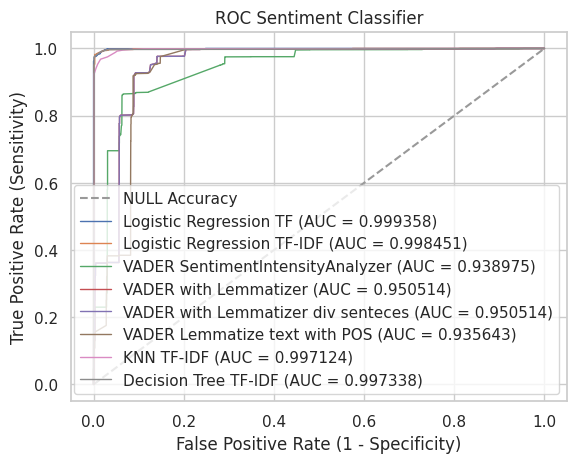

In [95]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_lem2, tpr_lem2, lw=1, label='VADER Lemmatize text with POS (AUC = %0.6f)' % roc_auc_lem2)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
#plt.plot(fpr_cnn, tpr_cnn, lw=1, label='Convolutional Neural Network (AUC = %0.6f)' % roc_auc_cnn)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [137]:
#Recurrent Neural Network (RNN)

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_rnn.add(SimpleRNN(units=50))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_rnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_prob_rnn = model_rnn.predict(X_test).flatten()
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int)
fpr_rnn, tpr_rnn, thresholds = metrics.roc_curve(y_test, y_pred_prob_rnn)
roc_auc_rnn = metrics.auc(fpr_rnn, tpr_rnn)

print(f"ROC AUC: {roc_auc_rnn}")


Epoch 1/5
149/149 [==============================] - 9s 53ms/step - loss: 0.2594 - auc: 0.9681 - val_loss: 0.1134 - val_auc: 0.9957
Epoch 2/5
149/149 [==============================] - 6s 39ms/step - loss: 0.0428 - auc: 0.9994 - val_loss: 0.0582 - val_auc: 0.9982
Epoch 3/5
149/149 [==============================] - 7s 50ms/step - loss: 0.0090 - auc: 1.0000 - val_loss: 0.0634 - val_auc: 0.9977
Epoch 4/5
149/149 [==============================] - 6s 39ms/step - loss: 0.0067 - auc: 1.0000 - val_loss: 0.0483 - val_auc: 0.9983
Epoch 5/5
74/74 [==============================] - 1s 8ms/step
ROC AUC: 0.998674963069072


In [138]:
add_model_metrics('RNN', y_test, y_pred_rnn, y_pred_prob_rnn, "selection")

In [139]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a LSTM layer
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # set to True if stacking LSTM layers, else False
        dropout=hp.Float('lstm_dropout', min_value=0.0, max_value=0.5, step=0.1),  # dropout for input
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.0, max_value=0.5, step=0.1)  # dropout for recurrent state
    ))

    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout after dense layer

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_rnn = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_rnn)
print("ROC AUC Score:", roc_auc)


Trial 3 Complete [00h 01m 32s]
val_loss: 0.14426130056381226

Best val_loss So Far: 0.03776315227150917
Total elapsed time: 00h 04m 23s
74/74 [==============================] - 6s 27ms/step - loss: 0.0378 - auc: 0.9985
Test Loss, Test AUC: [0.03776315227150917, 0.998530924320221]
74/74 [==============================] - 3s 24ms/step
ROC AUC Score: 0.9992889863765909


In [140]:
add_model_metrics('RNN_dropout', y_test, y_pred_cnn, y_pred_prob_cnn, "selection")

In [ ]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a LSTM layer with dropout
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # set to True if stacking LSTM layers, else False
        dropout=hp.Float('lstm_dropout', min_value=0.0, max_value=0.5, step=0.1),  # dropout for input
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.0, max_value=0.5, step=0.1)  # dropout for recurrent state
    ))

    # Adding a Dense layer with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')
        )))

    model.add(keras.layers.Dropout(rate=hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout after dense layer

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_rnn = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int)  # Convert probabilities to binary class labels

from sklearn import metrics
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_rnn)
print("ROC AUC Score:", roc_auc)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |32                |lstm_units
0                 |0                 |lstm_dropout
0                 |0                 |recurrent_dropout
10                |10                |dense_units
1e-05             |1e-05             |l1_reg
1e-05             |1e-05             |l2_reg
0                 |0                 |dense_dropout
0.01              |0.01              |learning_rate



Epoch 1/5
149/149 [==============================] - 17s 81ms/step - loss: 0.1727 - auc: 0.9786 - val_loss: 0.0613 - val_auc: 0.9968
Epoch 2/5
149/149 [==============================] - 10s 65ms/step - loss: 0.0161 - auc: 0.9997 - val_loss: 0.0588 - val_auc: 0.9958
Epoch 3/5
149/149 [==============================] - 10s 68ms/step - loss: 0.0065 - auc: 0.9997 - val_loss: 0.0782 - val_auc: 0.9941
Epoch 4/5
135/149 [==========================>...] - ETA: 1s - loss: 0.0033 - auc: 1.0000

In [ ]:
add_model_metrics('RNN_reg_dropout', y_test, y_pred_cnn, y_pred_prob_cnn, "selection")

In [ ]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a LSTM layer
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False  # set to True if stacking LSTM layers, else False
    ))

    # Adding a Dense layer with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')
        )))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_rnn = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_rnn)
print("ROC AUC Score:", roc_auc)


In [ ]:
add_model_metrics('RNN_reg', y_test, y_pred_cnn, y_pred_prob_cnn, "selection")

In [ ]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a simple LSTM layer
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False  # Set to True if stacking LSTM layers, else False
    ))

    # Adding a Dense layer
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu'
    ))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_rnn = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_rnn)
print("ROC AUC Score:", roc_auc)


In [ ]:
add_model_metrics('RNN_gs', y_test, y_pred_cnn, y_pred_prob_cnn, "selection")

In [ ]:
#Choose the best RNN model
select_best_model()

# **LSTM**

In [ ]:
#LSTM

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_lstm.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

In [ ]:
y_pred_prob_lstm = model_lstm.predict(X_test).flatten()
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)
fpr_lstm, tpr_lstm, thresholds = metrics.roc_curve(y_test, y_pred_prob_lstm)
roc_auc_lstm = metrics.auc(fpr_lstm, tpr_lstm)

add_model_metrics('LSTM', y_test, y_pred_lstm, y_pred_prob_lstm, "selection")
print(f"ROC AUC: {roc_auc_lstm}")

In [ ]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a simple LSTM layer
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False  # Set to True if stacking LSTM layers, else False
    ))

    # Adding a Dense layer for output
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_lstm = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_lstm)
print("ROC AUC Score:", roc_auc)

In [ ]:
add_model_metrics('LSTM_gs', y_test, y_pred_lstm, y_pred_prob_lstm, "selection")

In [ ]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a simple LSTM layer
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False  # Set to True if stacking LSTM layers, else False
    ))

    # Adding a Dense layer for output with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')
        )))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_lstm = best_model.predict(X_test). flatten()  # Get the probabilities
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_lstm)
print("ROC AUC Score:", roc_auc)

In [ ]:
add_model_metrics('LSTM_reg', y_test, y_pred_lstm, y_pred_prob_lstm, "selection")

In [ ]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a LSTM layer with dropout and recurrent dropout
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking LSTM layers, else False
        dropout=hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_rate', min_value=0, max_value=0.5, step=0.1)
    ))

    # Adding a Dense layer with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')
        )))

    # Adding dropout after the Dense layer
    model.add(keras.layers.Dropout(hp.Float('dense_dropout_rate', min_value=0, max_value=0.5, step=0.1)))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_lstm = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_lstm)
print("ROC AUC Score:", roc_auc)

In [ ]:
add_model_metrics('LSTM_reg_dropout', y_test, y_pred_lstm, y_pred_prob_lstm, "selection")

In [ ]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a LSTM layer with dropout and recurrent dropout
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking LSTM layers, else False
        dropout=hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_rate', min_value=0, max_value=0.5, step=0.1)
    ))

    # Adding a Dense layer for output
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Optional: Adding dropout after the Dense layer
    model.add(keras.layers.Dropout(hp.Float('dense_dropout_rate', min_value=0, max_value=0.5, step=0.1)))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_lstm = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_lstm)
print("ROC AUC Score:", roc_auc)

In [ ]:
add_model_metrics('LSTM_dropout', y_test, y_pred_lstm, y_pred_prob_lstm, "selection")

In [ ]:
#Choose the best LSTM model
select_best_model()

# **GRU**

In [ ]:
#GRU
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_gru.add(GRU(units=50))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_gru.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

In [ ]:
y_pred_prob_gru = model_gru.predict(X_test).flatten()
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)
fpr_gru, tpr_gru, thresholds = metrics.roc_curve(y_test, y_pred_prob_gru)
roc_auc_gru = metrics.auc(fpr_gru, tpr_gru)
add_model_metrics('GRU', y_test, y_pred_gru, y_pred_prob_gru, "selection")

print(f"ROC AUC: {roc_auc_gru}")

In [ ]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a GRU layer
    model.add(keras.layers.GRU(
        units=hp.Int('gru_units', min_value=32, max_value=256, step=32),
        return_sequences=False  # Set to True if stacking GRU layers, else False
    ))

    # Adding a Dense layer for output
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='gru_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_gru = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_gru)
print("ROC AUC Score:", roc_auc)

In [ ]:
add_model_metrics('GRU_gs', y_test, y_pred_gru, y_pred_prob_gru, "selection")

In [ ]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a GRU layer with L1 and L2 regularization
    model.add(keras.layers.GRU(
        units=hp.Int('gru_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking GRU layers, else False
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg_gru', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg_gru', min_value=1e-5, max_value=1e-2, sampling='log')
        )
    ))

    # Adding a Dense layer for output with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg_dense', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg_dense', min_value=1e-5, max_value=1e-2, sampling='log')
        )))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='gru_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_gru = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_gru)
print("ROC AUC Score:", roc_auc)

In [ ]:
add_model_metrics('GRU_reg', y_test, y_pred_gru, y_pred_prob_gru, "selection")

In [ ]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a GRU layer with dropout and recurrent dropout
    model.add(keras.layers.GRU(
        units=hp.Int('gru_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking GRU layers, else False
        dropout=hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_rate', min_value=0, max_value=0.5, step=0.1)
    ))

    # Adding a Dense layer for output
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Optional: Adding dropout after the Dense layer
    model.add(keras.layers.Dropout(hp.Float('dense_dropout_rate', min_value=0, max_value=0.5, step=0.1)))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='gru_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_gru = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_gru)
print("ROC AUC Score:", roc_auc)

In [ ]:
add_model_metrics('GRU_dropout', y_test, y_pred_gru, y_pred_prob_gru, "selection")

In [ ]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a GRU layer with dropout, recurrent dropout and L1, L2 regularization
    model.add(keras.layers.GRU(
        units=hp.Int('gru_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking GRU layers, else False
        dropout=hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_rate', min_value=0, max_value=0.5, step=0.1),
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')
        )
    ))

    # Adding a Dense layer for output with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')
        )))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='gru_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results)

y_pred_prob_gru = best_model.predict(X_test).flatten()  # Get the probabilities
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_gru)
print("ROC AUC Score:", roc_auc)

In [ ]:
add_model_metrics('GRU_reg_dropout', y_test, y_pred_gru, y_pred_prob_gru, "selection")

In [ ]:
#Choose the best GRU model
select_best_model()

In [ ]:
# Obliczanie wartości dla krzywej PR
precision, recall, thresholds = metrics.precision_recall_curve(y_pred_gru, y_pred_prob_gru)

# Rysowanie krzywej PR
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(15, 7))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random model')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_lem2, tpr_lem2, lw=1, label='VADER Lemmatize text with POS (AUC = %0.6f)' % roc_auc_lem2)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
#plt.plot(fpr_cnn, tpr_cnn, lw=1, label='Convolutional Neural Network (AUC = %0.6f)' % roc_auc_cnn)
plt.plot(fpr_rnn, tpr_rnn, lw=1, label='Recurrent Neural Network (AUC = %0.6f)' % roc_auc_rnn)
plt.plot(fpr_lstm, tpr_lstm, lw=1, label='LSTM (AUC = %0.6f)' % roc_auc_lstm)
plt.plot(fpr_gru, tpr_gru, lw=1, label='GRU (AUC = %0.6f)' % roc_auc_gru)

plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [ ]:
# def get_palette(metric_values, base_color="blue"):
#     # Normalize the metric values to range between 0 and 1
#     normalized = (metric_values - metric_values.min()) / (metric_values.max() - metric_values.min())
#     # Create a palette that darkens with higher values
#     palette = sns.dark_palette(base_color, n_colors=len(metric_values))
#     # Sort the palette by metric values, reversed for darker colors at higher values
#     return [palette[i] for i in normalized.argsort()[::-1]]


In [ ]:
df_model_metrics = pd.DataFrame(model_metrics).T
df_model_metrics

In [ ]:

# Assuming 'y_true' contains the actual labels corresponding to the predictions and probabilities
# y_true = np.array([...])  # You need to provide this

# Accessing model probabilities and plotting PR curves
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, model_data in model_metrics.items():
    # Extract probabilities and true labels
    y_scores = np.array(model_data['y_probs'])
    y_true = np.array(model_data['y_pred'])  # Only if y_pred corresponds to true labels

    # Compute precision-recall values
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    # Plot the precision-recall curve for the model
    ax.plot(recall, precision, label=f'PR Curve for {model_name}')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves for Models')
ax.legend(loc="best")
plt.show()


In [ ]:

# Rysowanie wykresu
plt.figure(figsize=(10, 8))
for model_name, metrics in model_metrics.items():
    precision = metrics['precision']
    recall = metrics['recall']
    pr_auc = metrics['pr_auc']
    plt.scatter(recall, precision, label=f'{model_name} (PR AUC={pr_auc:.2f})')

plt.title('Precision-Recall Points for Models')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Suppress future warnings locally
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Define the layout of the subplots
    # Assuming the first two keys are not metrics
    num_metrics = len(df_model_metrics) - 3
    num_columns = 3
    num_rows = (num_metrics + num_columns - 1) // num_columns  # Round up the division

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 5), sharey='row')
    fig.suptitle('Performance Metrics Comparison Across Models', fontsize=16)

    # Flatten axes array and hide unused axes
    axes = axes.flatten()
    for ax in axes[num_metrics:]:
        ax.set_visible(False)

    # Loop through each metric starting from the third one and create a bar plot
    for ax, (metric, values) in zip(axes, df_model_metrics.iloc[2:].iterrows()):

        # Calculate mean for each model's predictions
        means = [np.mean(pred) if isinstance(pred, np.ndarray) or isinstance(pred, pd.Series) else pred for pred in values]

        sns.barplot(ax=ax, x=values.index.tolist(), y=means, palette='light:b', width=0.8)
        ax.set_title(metric)
        ax.set_ylabel('Value')
        ax.set_xlabel('Model')
        ax.tick_params(axis='x', rotation=90)

        # Adjusting the annotation placement
        for p in ax.patches:
            value = p.get_height()
            x = p.get_x() + p.get_width() / 2
            # Adjusting y to ensure the annotation always fits within the plot area
            if value >= ax.get_ylim()[1] * 0.9:  # If value is within the top 5% of the y-axis
                y = ax.get_ylim()[1] * 0.85  # Lower the annotation to 95% of the y-axis height
            else:
                y = value + 0.01 * ax.get_ylim()[1]  # Else, slightly above the bar
            ax.annotate(f"{value:.2f}", (x, y), ha='center', va='bottom', fontsize=10, color='#06172a', xytext=(0, 3), textcoords='offset points')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
# Transpose the DataFrame for easier plotting
df_model_metrics = df_model_metrics.T

In [ ]:
def select_top_best_models(metrics_dict=None, drop=True, top_n=3):
    # Use a global dictionary if none is provided
    if metrics_dict is None:
        global model_metrics_temp
        metrics_dict = model_metrics_temp

    # Add calculated scores to each model's metrics
    for model_name, model_measures in metrics_dict.items():
        weights = {'Precision': 0.2, 'Recall': 0.2, 'F1 Score': 0.3, 'Auc': 0.2}
        normalized_measures = {key.capitalize(): value for key, value in model_measures.items() if key.capitalize() in weights}
        model_measures['Score'] = calculate_aggregated_metric_from_dict(normalized_measures, weights)

    # Sort and select the top models based on the newly added 'Score'
    best_models = sorted(metrics_dict.items(), key=lambda x: x[1]['Score'], reverse=True)[:top_n]
    top_models_dict = {model_name: measures for model_name, measures in best_models}

    # Display metrics for the top models
    if top_models_dict:
        for model_name, measures in top_models_dict.items():
            print(f"Selected top model: {model_name}")
            print("Model metrics:")
            print(*(f"{k}: {v}" for k, v in measures.items() if k != 'Score'), sep="\n")
            print("Score:", measures['Score'])
    else:
        print("No valid models were found.")

    # Optionally clear the original metrics dictionary
    if drop:
        metrics_dict.clear()

    # Return the dictionary containing only the best models
    return top_models_dict

def calculate_weighted_score(metrics, weights):
    total_weight = sum(weights.values())
    aggregated_score = sum(metrics[metric] * weights[metric] for metric in metrics if metric in weights)

    if total_weight == 0:
        raise ValueError("The sum of the weights cannot be equal to zero.")

    return aggregated_score / total_weight

def calculate_aggregated_metric_from_dict(data, weights):
    normalized_data = {key.capitalize(): value for key, value in data.items() if key.capitalize() in weights}
    return calculate_weighted_score(normalized_data, weights)


In [ ]:
select_top_best_models(metrics_dict=model_metrics, drop=False, top_n=3)

In [ ]:
# sorted_models = sorted(model_metrics.items(), key=lambda x: x[1]['auc'], reverse=True)

# top_models = sorted_models[:3]

# print("Top 3 Models Based on AUC:")
# for model in top_models:
#     print(f"Model Name: {model[0]}, AUC: {model[1]['auc']}")

In [ ]:
# Convert to DataFrame
df_top_models = pd.DataFrame({name: metrics for name, metrics in top_models}).T  # Transpose to make models the rows
df_top_models.reset_index(inplace=True)
df_top_models.rename(columns={'index': 'Model'}, inplace=True)

In [ ]:
df_top_models

In [ ]:
# Suppress future warnings locally
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Transpose the DataFrame for easier plotting of metrics (skipping 'y_pred' and 'y_probs' columns)
    df_plot = df_top_models.set_index('Model').drop(columns=['y_pred', 'y_probs', 'auc']).transpose()

    # Define the layout of the subplots
    num_metrics = len(df_plot)
    num_columns = 3
    num_rows = (num_metrics + num_columns - 1) // num_columns  # Round up the division

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 5), sharey=True)
    fig.suptitle('Performance Metrics Comparison Across Models', fontsize=16)

    # Flatten axes array and hide unused axes
    axes = axes.flatten()
    for ax in axes[num_metrics:]:
        ax.set_visible(False)

    # Loop through each metric and create a bar plot
    for ax, (metric, values) in zip(axes, df_plot.iterrows()):
        sns.barplot(ax=ax, x=values.index, y=values.values, palette='light:b', width=0.8)
        ax.set_title(metric)
        ax.set_ylabel('Value')
        ax.set_xlabel('Model')
        ax.tick_params(axis='x', rotation=45)

        # Adjusting the annotation placement
        for p in ax.patches:
            value = p.get_height()
            x = p.get_x() + p.get_width() / 2
            # Adjusting y to ensure the annotation always fits within the plot area
            if value >= ax.get_ylim()[1] * 0.9:  # If value is within the top 10% of the y-axis
                y = ax.get_ylim()[1] * 0.85  # Lower the annotation to 85% of the y-axis height
            else:
                y = value + 0.01 * ax.get_ylim()[1]  # Else, slightly above the bar
            ax.annotate(f"{value:.2f}", (x, y), ha='center', va='bottom', fontsize=10, color='#06172a', xytext=(0, 3), textcoords='offset points')

    # Adjust layout to prevent label overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot
    plt.show()
